# Method 2 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

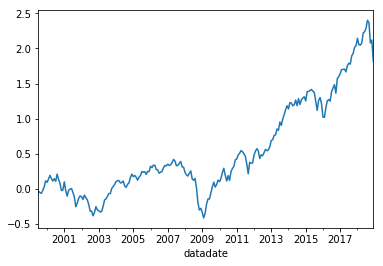

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.115828
2000-12-31   -0.117316
2001-12-31   -0.084410
2002-12-31   -0.220174
2003-12-31    0.513089
2004-12-31    0.138970
2005-12-31    0.030380
2006-12-31    0.064621
2007-12-31   -0.014790
2008-12-31   -0.445500
2009-12-31    0.550264
2010-12-31    0.257137
2011-12-31   -0.033313
2012-12-31    0.170437
2013-12-31    0.364261
2014-12-31    0.058497
2015-12-31   -0.043107
2016-12-31    0.173829
2017-12-31    0.169540
2018-12-31   -0.071530
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1003.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.23e-144
Time:                        03:41:51   Log-Likelihood:                 692.44
No. Observations:                 234   AIC:                            -1375.
Df Residuals:                     229   BIC:                            -1358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.225      0.027       0.000       0.004
mktrf          1.0206      0.024     43.138      0.000       0.974       1.067
me             0.2075      0.028      7.541      0.000       0.153       0.262
ia             0.1007      0.042      2.408      0.017       0.018       0.183
roe           -0.3028      0.036     -8.456      0.000      -0.373      -0.232
==============================================================================
Omnibus:                       57.780   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.497
Skew:                           0.808   Prob(JB):                     1.26e-71
Kurtosis:                       8.556   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     919.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.18e-140
Time:                        03:41:51   Log-Likelihood:                 692.44
No. Observations:                 234   AIC:                            -1375.
Df Residuals:                     229   BIC:                            -1358.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.267      0.023       0.000       0.004
mktrf          1.0206      0.036     28.401      0.000       0.950       1.091
me             0.2075      0.094      2.203      0.028       0.023       0.392
ia             0.1007      0.088      1.145      0.252      -0.072       0.273
roe           -0.3028      0.067     -4.516      0.000      -0.434      -0.171
==============================================================================
Omnibus:                       57.780   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.497
Skew:                           0.808   Prob(JB):                     1.26e-71
Kurtosis:                       8.556   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1383.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.54e-159
Time:                        03:41:51   Log-Likelihood:                 692.44
No. Observations:                 234   AIC:                            -1375.
Df Residuals:                     229   BIC:                            -1358.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.340      0.019       0.000       0.004
mktrf          1.0206      0.032     31.824      0.000       0.958       1.083
me             0.2075      0.100      2.082      0.037       0.012       0.403
ia             0.1007      0.079      1.275      0.202      -0.054       0.256
roe           -0.3028      0.064     -4.742      0.000      -0.428      -0.178
==============================================================================
Omnibus:                       57.780   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.497
Skew:                           0.808   Prob(JB):                     1.26e-71
Kurtosis:                       8.556   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     673.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.29e-134
Time:                        03:41:51   Log-Likelihood:                 673.72
No. Observations:                 234   AIC:                            -1335.
Df Residuals:                     228   BIC:                            -1315.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.129      0.260      -0.001       0.003
mktrf          1.0634      0.026     41.319      0.000       1.013       1.114
smb            0.2994      0.034      8.816      0.000       0.232       0.366
hml            0.1924      0.040      4.806      0.000       0.114       0.271
rmw           -0.1433      0.045     -3.165      0.002      -0.233      -0.054
cma           -0.1344      0.058     -2.335      0.020      -0.248      -0.021
==============================================================================
Omnibus:                       60.169   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.612
Skew:                           0.962   Prob(JB):                     3.80e-55
Kurtosis:                       7.691   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     396.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.00e-110
Time:                        03:41:51   Log-Likelihood:                 673.72
No. Observations:                 234   AIC:                            -1335.
Df Residuals:                     228   BIC:                            -1315.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.056      0.291      -0.001       0.003
mktrf          1.0634      0.030     35.339      0.000       1.004       1.122
smb            0.2994      0.080      3.761      0.000       0.143       0.455
hml            0.1924      0.073      2.648      0.008       0.050       0.335
rmw           -0.1433      0.070     -2.052      0.040      -0.280      -0.006
cma           -0.1344      0.107     -1.253      0.210      -0.345       0.076
==============================================================================
Omnibus:                       60.169   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.612
Skew:                           0.962   Prob(JB):                     3.80e-55
Kurtosis:                       7.691   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     391.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.91e-110
Time:                        03:41:52   Log-Likelihood:                 673.72
No. Observations:                 234   AIC:                            -1335.
Df Residuals:                     228   BIC:                            -1315.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.040      0.298      -0.001       0.003
mktrf          1.0634      0.030     35.504      0.000       1.005       1.122
smb            0.2994      0.076      3.914      0.000       0.149       0.449
hml            0.1924      0.065      2.940      0.003       0.064       0.321
rmw           -0.1433      0.072     -1.991      0.046      -0.284      -0.002
cma           -0.1344      0.114     -1.183      0.237      -0.357       0.088
==============================================================================
Omnibus:                       60.169   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.612
Skew:                           0.962   Prob(JB):                     3.80e-55
Kurtosis:                       7.691   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1345.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.63e-158
Time:                        03:41:52   Log-Likelihood:                 725.24
No. Observations:                 234   AIC:                            -1440.
Df Residuals:                     229   BIC:                            -1423.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.783      0.076      -0.000       0.003
mktrf          1.0197      0.019     53.857      0.000       0.982       1.057
smb            0.3850      0.024     16.287      0.000       0.338       0.432
hml            0.1053      0.023      4.484      0.000       0.059       0.152
umd           -0.1969      0.015    -12.780      0.000      -0.227      -0.167
==============================================================================
Omnibus:                        7.156   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               11.999
Skew:                           0.039   Prob(JB):                      0.00248
Kurtosis:                       4.107   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1667.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.45e-168
Time:                        03:41:52   Log-Likelihood:                 725.24
No. Observations:                 234   AIC:                            -1440.
Df Residuals:                     229   BIC:                            -1423.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.507      0.132      -0.000       0.003
mktrf          1.0197      0.019     54.837      0.000       0.983       1.056
smb            0.3850      0.063      6.100      0.000       0.261       0.509
hml            0.1053      0.032      3.331      0.001       0.043       0.167
umd           -0.1969      0.028     -7.068      0.000      -0.251      -0.142
==============================================================================
Omnibus:                        7.156   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               11.999
Skew:                           0.039   Prob(JB):                      0.00248
Kurtosis:                       4.107   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1407.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.15e-160
Time:                        03:41:52   Log-Likelihood:                 725.24
No. Observations:                 234   AIC:                            -1440.
Df Residuals:                     229   BIC:                            -1423.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.539      0.124      -0.000       0.003
mktrf          1.0197      0.019     53.552      0.000       0.982       1.057
smb            0.3850      0.064      5.977      0.000       0.259       0.511
hml            0.1053      0.030      3.525      0.000       0.047       0.164
umd           -0.1969      0.028     -7.131      0.000      -0.251      -0.143
==============================================================================
Omnibus:                        7.156   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               11.999
Skew:                           0.039   Prob(JB):                      0.00248
Kurtosis:                       4.107   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     467.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.88e-70
Time:                        03:41:52   Log-Likelihood:                 335.14
No. Observations:                 120   AIC:                            -660.3
Df Residuals:                     115   BIC:                            -646.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      1.948      0.054   -4.77e-05       0.006
mktrf          1.0473      0.039     26.840      0.000       0.970       1.125
me             0.1297      0.039      3.366      0.001       0.053       0.206
ia             0.1081      0.060      1.791      0.076      -0.011       0.228
roe           -0.2955      0.053     -5.533      0.000      -0.401      -0.190
==============================================================================
Omnibus:                       22.320   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.046
Skew:                           0.707   Prob(JB):                     8.23e-12
Kurtosis:                       5.865   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     503.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.53e-72
Time:                        03:41:52   Log-Likelihood:                 335.14
No. Observations:                 120   AIC:                            -660.3
Df Residuals:                     115   BIC:                            -646.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.809      0.071      -0.000       0.006
mktrf          1.0473      0.043     24.381      0.000       0.963       1.131
me             0.1297      0.093      1.388      0.165      -0.054       0.313
ia             0.1081      0.095      1.137      0.255      -0.078       0.294
roe           -0.2955      0.072     -4.131      0.000      -0.436      -0.155
==============================================================================
Omnibus:                       22.320   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.046
Skew:                           0.707   Prob(JB):                     8.23e-12
Kurtosis:                       5.865   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     704.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.40e-80
Time:                        03:41:52   Log-Likelihood:                 335.14
No. Observations:                 120   AIC:                            -660.3
Df Residuals:                     115   BIC:                            -646.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.697      0.090      -0.000       0.006
mktrf          1.0473      0.035     29.699      0.000       0.978       1.116
me             0.1297      0.099      1.309      0.190      -0.064       0.324
ia             0.1081      0.084      1.290      0.197      -0.056       0.272
roe           -0.2955      0.061     -4.874      0.000      -0.414      -0.177
==============================================================================
Omnibus:                       22.320   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.046
Skew:                           0.707   Prob(JB):                     8.23e-12
Kurtosis:                       5.865   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     301.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.21e-64
Time:                        03:41:52   Log-Likelihood:                 323.39
No. Observations:                 120   AIC:                            -634.8
Df Residuals:                     114   BIC:                            -618.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.340      0.183      -0.001       0.005
mktrf          1.1470      0.046     25.165      0.000       1.057       1.237
smb            0.2547      0.052      4.934      0.000       0.152       0.357
hml            0.1376      0.063      2.175      0.032       0.012       0.263
rmw           -0.0732      0.075     -0.982      0.328      -0.221       0.075
cma           -0.0956      0.082     -1.169      0.245      -0.257       0.066
==============================================================================
Omnibus:                       26.954   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.919
Skew:                           0.913   Prob(JB):                     7.20e-13
Kurtosis:                       5.802   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     297.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.27e-63
Time:                        03:41:52   Log-Likelihood:                 323.39
No. Observations:                 120   AIC:                            -634.8
Df Residuals:                     114   BIC:                            -618.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.311      0.190      -0.001       0.006
mktrf          1.1470      0.040     28.512      0.000       1.068       1.226
smb            0.2547      0.102      2.492      0.013       0.054       0.455
hml            0.1376      0.081      1.704      0.088      -0.021       0.296
rmw           -0.0732      0.081     -0.903      0.367      -0.232       0.086
cma           -0.0956      0.124     -0.772      0.440      -0.338       0.147
==============================================================================
Omnibus:                       26.954   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.919
Skew:                           0.913   Prob(JB):                     7.20e-13
Kurtosis:                       5.802   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     316.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.18e-65
Time:                        03:41:52   Log-Likelihood:                 323.39
No. Observations:                 120   AIC:                            -634.8
Df Residuals:                     114   BIC:                            -618.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.272      0.203      -0.001       0.006
mktrf          1.1470      0.039     29.470      0.000       1.071       1.223
smb            0.2547      0.094      2.710      0.007       0.070       0.439
hml            0.1376      0.076      1.805      0.071      -0.012       0.287
rmw           -0.0732      0.082     -0.892      0.372      -0.234       0.088
cma           -0.0956      0.127     -0.751      0.453      -0.345       0.154
==============================================================================
Omnibus:                       26.954   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.919
Skew:                           0.913   Prob(JB):                     7.20e-13
Kurtosis:                       5.802   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     660.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.52e-78
Time:                        03:41:52   Log-Likelihood:                 354.83
No. Observations:                 120   AIC:                            -699.7
Df Residuals:                     115   BIC:                            -685.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.948      0.054   -3.96e-05       0.005
mktrf          1.0572      0.029     36.240      0.000       0.999       1.115
smb            0.3377      0.033     10.168      0.000       0.272       0.404
hml            0.0931      0.033      2.799      0.006       0.027       0.159
umd           -0.1944      0.021     -9.477      0.000      -0.235      -0.154
==============================================================================
Omnibus:                        1.023   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.734
Skew:                          -0.186   Prob(JB):                        0.693
Kurtosis:                       3.096   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1809.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.56e-103
Time:                        03:41:52   Log-Likelihood:                 354.83
No. Observations:                 120   AIC:                            -699.7
Df Residuals:                     115   BIC:                            -685.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.603      0.109      -0.001       0.005
mktrf          1.0572      0.022     47.207      0.000       1.013       1.101
smb            0.3377      0.069      4.876      0.000       0.202       0.473
hml            0.0931      0.037      2.501      0.012       0.020       0.166
umd           -0.1944      0.032     -6.103      0.000      -0.257      -0.132
==============================================================================
Omnibus:                        1.023   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.734
Skew:                          -0.186   Prob(JB):                        0.693
Kurtosis:                       3.096   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2812.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.15e-113
Time:                        03:41:52   Log-Likelihood:                 354.83
No. Observations:                 120   AIC:                            -699.7
Df Residuals:                     115   BIC:                            -685.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.604      0.109      -0.001       0.005
mktrf          1.0572      0.021     49.850      0.000       1.016       1.099
smb            0.3377      0.071      4.772      0.000       0.199       0.476
hml            0.0931      0.040      2.343      0.019       0.015       0.171
umd           -0.1944      0.033     -5.961      0.000      -0.258      -0.130
==============================================================================
Omnibus:                        1.023   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.734
Skew:                          -0.186   Prob(JB):                        0.693
Kurtosis:                       3.096   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1016.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.92e-85
Time:                        03:41:52   Log-Likelihood:                 402.25
No. Observations:                 114   AIC:                            -794.5
Df Residuals:                     109   BIC:                            -780.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.181      0.002       0.001       0.004
mktrf          0.9314      0.021     43.620      0.000       0.889       0.974
me             0.4667      0.033     14.156      0.000       0.401       0.532
ia             0.0528      0.046      1.156      0.250      -0.038       0.143
roe           -0.3132      0.040     -7.794      0.000      -0.393      -0.234
==============================================================================
Omnibus:                       75.157   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.902
Skew:                           1.989   Prob(JB):                    1.14e-149
Kurtosis:                      14.339   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1239.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.66e-90
Time:                        03:41:52   Log-Likelihood:                 402.25
No. Observations:                 114   AIC:                            -794.5
Df Residuals:                     109   BIC:                            -780.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.351      0.001       0.001       0.004
mktrf          0.9314      0.019     49.462      0.000       0.894       0.968
me             0.4667      0.039     11.947      0.000       0.390       0.543
ia             0.0528      0.053      0.998      0.318      -0.051       0.157
roe           -0.3132      0.055     -5.664      0.000      -0.422      -0.205
==============================================================================
Omnibus:                       75.157   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.902
Skew:                           1.989   Prob(JB):                    1.14e-149
Kurtosis:                      14.339   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1614.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.53e-96
Time:                        03:41:52   Log-Likelihood:                 402.25
No. Observations:                 114   AIC:                            -794.5
Df Residuals:                     109   BIC:                            -780.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.684      0.000       0.001       0.004
mktrf          0.9314      0.018     50.544      0.000       0.895       0.967
me             0.4667      0.043     10.859      0.000       0.382       0.551
ia             0.0528      0.054      0.970      0.332      -0.054       0.160
roe           -0.3132      0.057     -5.506      0.000      -0.425      -0.202
==============================================================================
Omnibus:                       75.157   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.902
Skew:                           1.989   Prob(JB):                    1.14e-149
Kurtosis:                      14.339   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     668.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.68e-79
Time:                        03:41:52   Log-Likelihood:                 391.96
No. Observations:                 114   AIC:                            -771.9
Df Residuals:                     108   BIC:                            -755.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.427      0.157      -0.000       0.003
mktrf          0.9523      0.022     42.533      0.000       0.908       0.997
smb            0.4595      0.036     12.643      0.000       0.387       0.532
hml            0.1536      0.046      3.313      0.001       0.062       0.245
rmw           -0.2218      0.057     -3.908      0.000      -0.334      -0.109
cma           -0.0439      0.072     -0.609      0.544      -0.187       0.099
==============================================================================
Omnibus:                       41.057   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.029
Skew:                           1.246   Prob(JB):                     2.14e-29
Kurtosis:                       7.646   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     744.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.17e-82
Time:                        03:41:52   Log-Likelihood:                 391.96
No. Observations:                 114   AIC:                            -771.9
Df Residuals:                     108   BIC:                            -755.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.251      0.211      -0.001       0.003
mktrf          0.9523      0.018     51.770      0.000       0.916       0.988
smb            0.4595      0.038     11.948      0.000       0.384       0.535
hml            0.1536      0.075      2.041      0.041       0.006       0.301
rmw           -0.2218      0.068     -3.244      0.001      -0.356      -0.088
cma           -0.0439      0.079     -0.558      0.577      -0.198       0.110
==============================================================================
Omnibus:                       41.057   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.029
Skew:                           1.246   Prob(JB):                     2.14e-29
Kurtosis:                       7.646   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     695.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.08e-80
Time:                        03:41:52   Log-Likelihood:                 391.96
No. Observations:                 114   AIC:                            -771.9
Df Residuals:                     108   BIC:                            -755.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.132      0.258      -0.001       0.003
mktrf          0.9523      0.019     50.245      0.000       0.915       0.989
smb            0.4595      0.042     11.009      0.000       0.378       0.541
hml            0.1536      0.073      2.104      0.035       0.010       0.297
rmw           -0.2218      0.066     -3.355      0.001      -0.351      -0.092
cma           -0.0439      0.085     -0.517      0.605      -0.210       0.123
==============================================================================
Omnibus:                       41.057   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.029
Skew:                           1.246   Prob(JB):                     2.14e-29
Kurtosis:                       7.646   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     889.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.27e-82
Time:                        03:41:52   Log-Likelihood:                 394.90
No. Observations:                 114   AIC:                            -779.8
Df Residuals:                     109   BIC:                            -766.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.467      0.145      -0.000       0.003
mktrf          0.9537      0.022     44.192      0.000       0.911       0.997
smb            0.5179      0.034     15.391      0.000       0.451       0.585
hml            0.1398      0.035      4.033      0.000       0.071       0.208
umd           -0.1351      0.026     -5.167      0.000      -0.187      -0.083
==============================================================================
Omnibus:                       34.517   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.215
Skew:                           1.030   Prob(JB):                     3.17e-24
Kurtosis:                       7.306   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     947.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.14e-83
Time:                        03:41:52   Log-Likelihood:                 394.90
No. Observations:                 114   AIC:                            -779.8
Df Residuals:                     109   BIC:                            -766.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.515      0.130      -0.000       0.003
mktrf          0.9537      0.019     51.365      0.000       0.917       0.990
smb            0.5179      0.038     13.720      0.000       0.444       0.592
hml            0.1398      0.061      2.285      0.022       0.020       0.260
umd           -0.1351      0.033     -4.069      0.000      -0.200      -0.070
==============================================================================
Omnibus:                       34.517   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.215
Skew:                           1.030   Prob(JB):                     3.17e-24
Kurtosis:                       7.306   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1118.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.76e-87
Time:                        03:41:52   Log-Likelihood:                 394.90
No. Observations:                 114   AIC:                            -779.8
Df Residuals:                     109   BIC:                            -766.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.396      0.163      -0.000       0.003
mktrf          0.9537      0.017     55.777      0.000       0.920       0.987
smb            0.5179      0.036     14.197      0.000       0.446       0.589
hml            0.1398      0.064      2.191      0.028       0.015       0.265
umd           -0.1351      0.030     -4.492      0.000      -0.194      -0.076
==============================================================================
Omnibus:                       34.517   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.215
Skew:                           1.030   Prob(JB):                     3.17e-24
Kurtosis:                       7.306   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""